1/1 [==============================] - 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


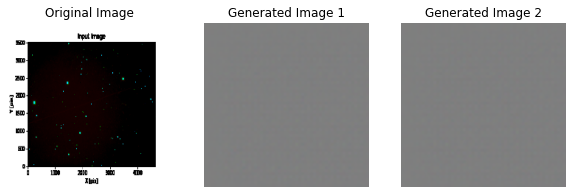

In [4]:
import os
import numpy as np
from datetime import datetime
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import cv2
import matplotlib.pyplot as plt

def preprocess_png(image_path):
    # Load PNG image and resize it to 224x224
    image_data = cv2.imread(image_path)
    resized_image = cv2.resize(image_data, (224, 224))
    # Normalize pixel values to be in the range [-1, 1]
    preprocessed_image = (resized_image.astype(np.float32) - 127.5) / 127.5
    return np.expand_dims(preprocessed_image, axis=0)

def generate_augmented_data(generator, num_samples):
    # Generate random noise as input to the generator
    random_input = np.random.randn(num_samples, 100)
    # Generate synthetic PNG images using the generator
    generated_images = generator.predict(random_input)
    # Denormalize pixel values to be in the range [0, 255]
    generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)
    return generated_images

# Define GAN architecture
generator = Sequential([
    Dense(7*7*256, input_shape=(100,), activation='relu'),
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')  # Output with 3 channels (RGB)
])

# Sample usage: Load a PNG image and preprocess it
sample_png_file = './Data/fits_filtered8/tic1.png'  # Change this to your PNG image file path
preprocessed_image = preprocess_png(sample_png_file)

# Sample usage: Generate augmented data using the GAN
num_samples = 2  # Adjust the number of samples according to your needs
generated_data = generate_augmented_data(generator, num_samples)

# Display the original PNG image
plt.figure(figsize=(10, 5))
plt.subplot(1, num_samples + 1, 1)
plt.imshow(preprocessed_image[0])
plt.title('Original Image')
plt.axis('off')

# Display the generated images
for i, image in enumerate(generated_data):
    plt.subplot(1, num_samples + 1, i + 2)
    plt.imshow(image)
    plt.title(f'Generated Image {i+1}')
    plt.axis('off')

plt.show()
